In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Elrond.Helpers.array_utility import pandas_collumn_to_2d_numpy_array
from scipy.signal import spectrogram, welch
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import pynapple as nap
from scipy.ndimage import gaussian_filter, rotate
from scipy.signal import find_peaks, peak_prominences, spectrogram
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

/opt/anaconda3/envs/sm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_firing_rate_map(ax, tc, tl):
    p = np.nanpercentile(tc, 99)
    tc = np.clip(tc, max=p)
    n_trials = (len(tc)//tl)
    trial_rate_map = []
    for i in range(n_trials):
        trial_rate_map.append(tc[int(i*tl): int((i+1)*tl)])
    trial_rate_map = np.array(trial_rate_map)    
    ax.imshow(trial_rate_map, cmap='binary')

def plot_avg_firing_rate_map(ax, tc, tl, c='black'):
    p = np.nanpercentile(tc, 99)
    tc = np.clip(tc, max=p)
    n_trials = (len(tc)//tl)
    trial_rate_map = []
    for i in range(n_trials):
        trial_rate_map.append(tc[int(i*tl): int((i+1)*tl)])
    trial_rate_map = np.array(trial_rate_map)    
    ax.plot(np.arange(230), np.nanmean(trial_rate_map,axis=0), color=c)
    ax.fill_between(np.arange(230), np.nanmean(trial_rate_map,axis=0)-stats.sem(trial_rate_map, axis=0,nan_policy="omit"),
                                    np.nanmean(trial_rate_map,axis=0)+stats.sem(trial_rate_map, axis=0,nan_policy="omit"),alpha=0.3, color=c)

In [3]:
mouse = 26
day = 24
session_type = 'MCVR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)


[63.13362122 63.19645405 63.25928688 ... 37.15970516 37.15970516
 37.15970516]
this mouse travelled 524.7734821081161 meters
using 52670 bins


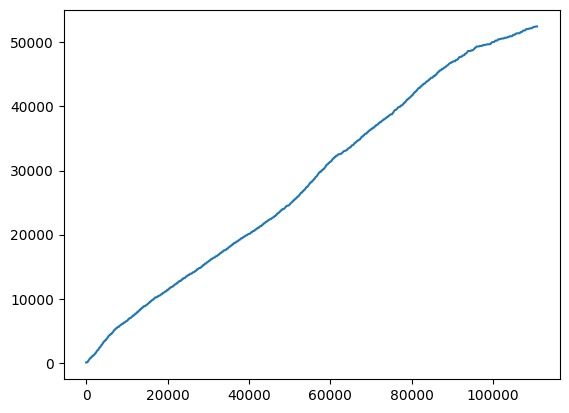

cluster_ids:[ 20  12  23  21  18  27  10  42  28  46  47  49  59  67  68  83  44 154
 196 202 213 224 231 225 235 240 234 247 248 255 263 269 301 297 310 316
 329 333 342 354 376 389 417]


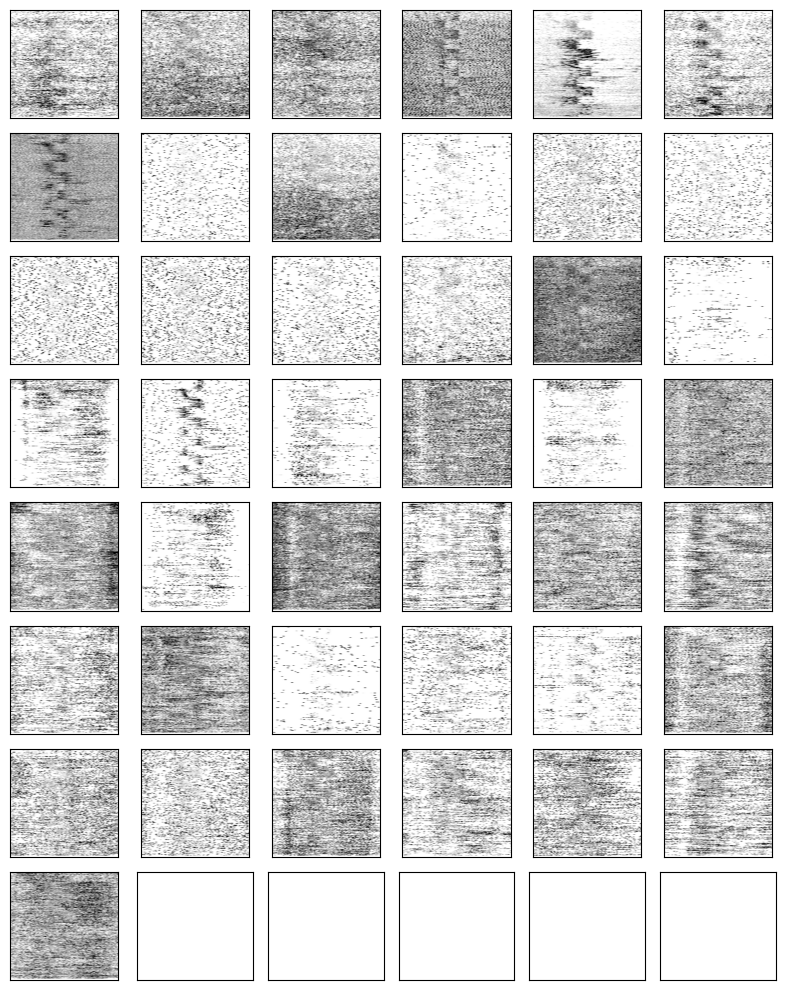

TypeError: plot_avg_firing_rate_map() missing 1 required positional argument: 'c'

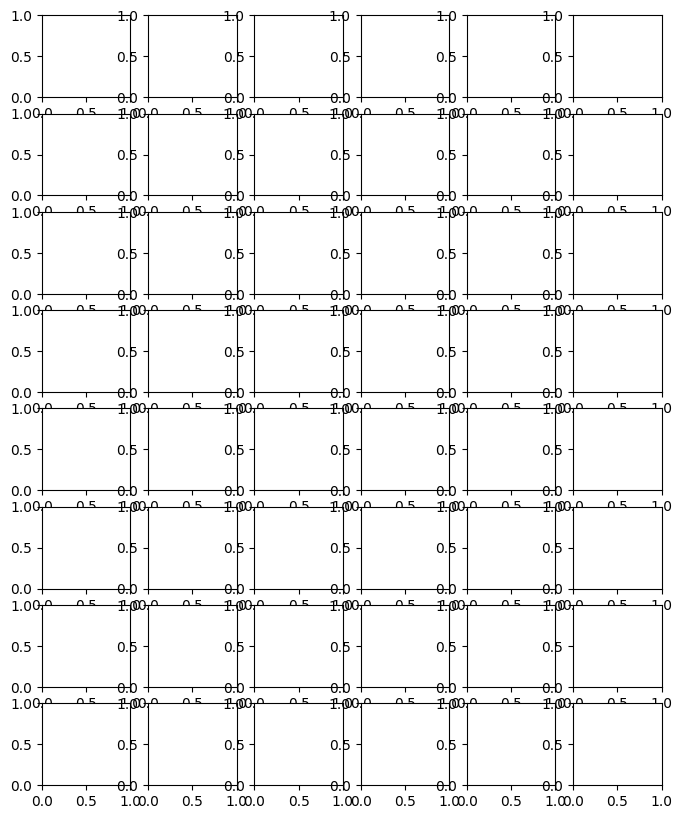

In [4]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']
bin_config = get_bin_config(session_type)['P']

track_length = 230
positions = np.array(session['P'])
print(positions)
times = np.array(session['P'].index)
trial_numbers = np.array(session['trial_number'])
distance_travelled = positions+(track_length*(trial_numbers-1))
distance_travelled_adjusted = distance_travelled-((trial_numbers[0]-1)*track_length)
print(f'this mouse travelled {np.nanmax(distance_travelled_adjusted)/100} meters')
n_bins = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//230)+1)*230)
max_bound = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//230)+1)*230)
min_bound = 0

print(f'using {n_bins} bins')
tmp_TSD = nap.TsdFrame(t=times, d=distance_travelled_adjusted, columns=['dt'])

plt.plot(distance_travelled_adjusted)
plt.show()
# Plot
groups = [
    ('rz1_b', (0, 1), 'blue'),
    ('rz1_nb', (0, 1), 'blue'),
    ('rz2_b', (2, 3), 'red'),
    ('rz2_nb', (2, 3), 'red'),
]
for (group, trial_group, color) in groups:
    regions = bin_config['regions'][trial_group]

    group_neurons_indices = ramp_scores[(ramp_scores['group'] == group) & 
                                        (ramp_scores['sign'] == '+') & 
                                        (ramp_scores['region'] == 'outbound')]['cluster_id'].values
    
    print(f'cluster_ids:{group_neurons_indices}')
    tcs = []
    for index in group_neurons_indices:
        this_neuron = neurons[neurons.index == index]
        tc = nap.compute_1d_tuning_curves(this_neuron, tmp_TSD["dt"], nb_bins=n_bins, minmax=[min_bound,max_bound])[index]
        mask = np.isnan(tc)
        tc = gaussian_filter(np.nan_to_num(tc).astype(np.float64), sigma=1.5)
        # top up to the end of a track length
        tc= np.append(tc, np.zeros(track_length-(len(tc)%track_length)))
        tcs.append(tc)

    ncols = 6
    nrows = int(np.ceil(len(tcs)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(tcs)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(tcs):
                plot_firing_rate_map(ax[j, i], 
                                     zscore(tcs[counter]), 
                                     tl=track_length)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            counter+=1
    plt.tight_layout()
    plt.show()


    ncols = 6
    nrows = int(np.ceil(len(tcs)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(tcs)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(tcs):
                plot_avg_firing_rate_map(ax[j, i], 
                                         zscore(tcs[counter]), 
                                         tl=track_length)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            counter+=1
    plt.tight_layout()
    plt.show()


In [ ]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']
bin_config = get_bin_config(session_type)['P']

track_length = 230
positions = np.array(session['P'])
print(positions)
times = np.array(session['P'].index)
trial_numbers = np.array(session['trial_number'])
distance_travelled = positions+(track_length*(trial_numbers-1))
distance_travelled_adjusted = distance_travelled-((trial_numbers[0]-1)*track_length)
print(f'this mouse travelled {np.nanmax(distance_travelled_adjusted)/100} meters')
n_bins = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//230)+1)*230)
max_bound = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//230)+1)*230)
min_bound = 0
print(f'using {n_bins} bins')
tmp_TSD = nap.TsdFrame(t=times, d=distance_travelled_adjusted, columns=['dt'])


neurons_indices = ramp_scores[(ramp_scores['group'] == 'rz1_b') & 
                              (ramp_scores['sign'] == '+') & 
                              (ramp_scores['region'] == 'outbound')]['cluster_id'].values
print(f'cluster_ids that are positive on the outbound zone for context 1-beaconed trials:{neurons_indices}')

ncols = 6
nrows = int(np.ceil(len(neurons_indices)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(neurons_indices)/6)/4)), squeeze=False)

# Plot
groups = [
    ('rz1_b', 0, 'black'),
    ('rz1_nb', 1, 'red'),
    ('rz2_b', 2, 'green'),
    ('rz2_nb', 3, 'blue'),
]
for (group, trial_type, color) in groups:
    regions = bin_config['regions'][trial_group]

    print(f'cluster_ids:{neurons_indices}')
    tcs = []
    for index in group_neurons_indices:
        this_neuron = neurons[neurons.index == index]
        tc = nap.compute_1d_tuning_curves(this_neuron, tmp_TSD["dt"][session['trial_type'] == trial_type], 
                                          nb_bins=n_bins, minmax=[min_bound,max_bound])[index]
        mask = np.isnan(tc)
        tc = gaussian_filter(np.nan_to_num(tc).astype(np.float64), sigma=1.5)
        # top up to the end of a track length
        tc= np.append(tc, np.zeros(track_length-(len(tc)%track_length)))
        tcs.append(tc)

    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(tcs):
                plot_avg_firing_rate_map(ax[j, i], 
                                         zscore(tcs[counter]), 
                                         tl=track_length,
                                         color=color)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            counter+=1
    plt.tight_layout()
    plt.show()
